# FIRE - Far-ultraviolet Irradiated Rotational Evolution model

## Period-mass diagrams

**Last update (Julia Roquette - 7th September 2021):** Worked on the Referee comments and produced a new Figure 1 for the paper.

**Previous updates**: 

**juliaroquette_4thAugust2021** Added to github.

**juliaroquette_27July2021** Updated plots according to the rules of MNRAS.

**juliaroquette_17July2021** This notebook presents the codes calculating isogyrochrones and for building the period-mass space plots in the paper.

In [3]:
import numpy as np
import matplotlib.pylab as plt

In [4]:
from FIREstars.SpinEvolution import SpinEvolutionCode, period2omega, omega2period
from FIREstars.FUVfunctions import DiskWithFUV

In [5]:
t0=0.55e6
spin=SpinEvolutionCode(t0)

The function `isogyrochrone` below is a tool for building isogyrochrones with the model described in `SpinEvolutionModel.ipynb`. Isogyrochrones are tracks in period-mass space where coeval stars in the mass-range 0.1$-$1.3 M$_\odot$ have their rotation evolved until a certain age while sharing the same initial rotation and FUV conditions. 

```python
    def isogyrochrone(self, initial_period, time, fuv=False, tau_d=False, 
                      dm=0.025, e=0.01, tau_vis=1.0, wind=True, 
                      structure=True, breakup=True, initial_age=False,
                      get_breakup_limit=False):
        """
        Calculate "isogyrochrones" by running the spin evolution model for the 
        range of masses 0.1-1.3Mo, considering coeval stars sharing the same 
        initial condition
        
        ---- 
        input:
        
        initial_period:            Initial Period for the isogyrochrones
        time:                      Isogyrochrone ages in years. It can be 
                                   either a single value or an array of values
        fuv [False]:               Set as False if no FUV level is considered. 
                                   Otherwise, give a value in units of G0 for 
                                   deriving disk-lifetimes from the Winter+20 
                                   models
        tau_d [False]:             disk-locking duration in years if want to 
                                   inform this parameter by hand, otherwise 
                                   leave as False and isogyrochrones will be 
                                   run without any disk-locking
        dm [0.025]:                Sets how many steps of mass will be 
                                   calculated (linearily) between the values 
                                   0.1 and 1.3Mo
        e [0.01]:                  tolerance parameter for the spin evolution 
                                   code. Sets by how much Omega will have to 
                                   change for a time-step to be calculated 
                                   with the Euler method
        wind [True]:               True for a Spin Evolution including the 
                                   wind-torque
        structure [True]:          True for a spin evolution including the 
                                   stellar structure variation terms
        breakup [True]:            True to prevent stars from ever rotating 
                                   faster than the break-up limit
        initial_age [False]:       If True, output will include an 
                                   isogyrochrone for the initial age which was
                                   defined when calling the 
                                   SpinEvolutionCode(t0)
        get_breakup_limit [False]: If True, returns the break-up limit as a
                                    function of mass and age
                           
        ----
        Usage:
        
        mass, period = isogyrochrone(initial_period, time, fuv=1000.)
        
        ----
        output: 

        mass:   array with masses in the isogyrochrone
        period: array with rotational periods in the isogyrochrone. Dimensions
                are [dimensions of time array, mass dimension]
        """
        try:
            len(time)
        except TypeError:
            time = np.array([time])
        else:
            time = np.array(time)
        if bool(fuv):
            from fire.FUVfunctions import DiskWithFUV
            disk = DiskWithFUV()
            get_tauD = lambda x: disk.get_tauD(x, fuv, tau_vis=tau_vis)
        elif bool(tau_d):
            get_tauD = lambda x: tau_d
        else: get_tauD = lambda x: 0.        
        mass = np.linspace(0.1, 1.3, int((1.3 - 0.1)/dm))      
        period_out = np.full((bool(initial_age).real + len(time), len(mass)),
                             np.nan)
        if not bool(get_breakup_limit):
            period_out[0,:] = bool(initial_age).real*initial_period 
            for i,m in enumerate(mass):
                period_out[:, i] = omega2period(self.dOmegadt(m, 
                                    period2omega(initial_period), time, 
                                    tau_d=get_tauD(m), e=e, wind=wind, 
                                    structure=structure, snapshot=True, 
                                    breakup=breakup)[1]\
                                            [1 - 1*bool(initial_age).real:])
        else:
            for i, m in enumerate(mass):
                period_out[:, i] = \
                    omega2period(self.get_BreakUp(m, np.insert(time, 0, 
                                                    self.t0.value, axis=0)))
        return mass, period_out
```

Here is a usage example for deriving an isogyrochrone with an initial rotation of 10 d, at 8 Myr of evolution for stars evolving under 1000G$_0$

In [60]:
t = 13e6
mass, period= spin.isogyrochrone(10., t, fuv=1000., tau_d=False, dm=0.02, 
                                 e=0.01, initial_age=False)

/Users/jroquette/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [8]:
import matplotlib.pyplot as plt

(0.1, 30)

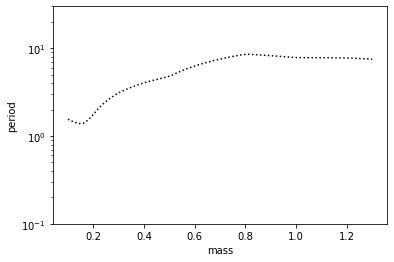

In [61]:
plt.plot(mass,period[0], 'k:')
plt.xlabel('mass')
plt.ylabel('period')
plt.yscale("log")
plt.ylim(0.1, 30)

This step is just to have a notion of the computation time of a single isogyrochrone:

In [62]:
%timeit spin.isogyrochrone(10., t, fuv=1000., tau_d=False, dm=0.02, e=0.01,
                           initial_age=False)

/Users/jroquette/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


1min 25s ± 3.06 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## isogyrochrones plot - paper results

In section 3.2 of the paper, I am showing a plot for models at different FUV inside the period-mass space, which was produced as below.

In the paper, I looked at the ages of NGC 2264 (3 Myr), USco (8 Myr), hPer (13 Myr), Pleiades (110 Myr), Praesepe (710 Myr), NGC 6811 (1,000 Myr), additionally to the initial age in the Baraffe models 0.55 Myr and the final age set to 4.5 Gyr (approx. age of the Sun)

In [6]:
time = 1e6*np.array([3., 8, 13., 110., 710., 1000., 4500.])

I will use the `DiskWithFUV` function to retreive the FUV levels for which the disk-model is calculated.

In [7]:
from FIREstars.FUVfunctions import DiskWithFUV

In [8]:
disk = DiskWithFUV()

In [9]:
paper_isogyrochrones = {}

This step is running isogyrochrones for $\tau_\mathrm{vis}=1$ Myr. This step can take a while to run, so if it was run and saved before, just skip to re-opening the file.

In [17]:
for tau_vis in [1.]:
    paper_isogyrochrones[str(int(tau_vis)) + 'Myr'] = {}
    for P0, speed in zip([1.6, 16.], ['fast', 'slow']):
        paper_isogyrochrones[str(int(tau_vis)) + 'Myr'][speed] = {}
        for FUV in disk.FUV:
            print(speed,FUV)
            paper_isogyrochrones[str(int(tau_vis)) + 'Myr'][speed] \
                            [str(int(FUV)) + 'G0'] = {}
            paper_isogyrochrones[str(int(tau_vis)) + 'Myr'][speed]\
                            [str(int(FUV)) + 'G0']['Mass'], \
                            paper_isogyrochrones[str(int(tau_vis)) + 'Myr']\
                            [speed][str(int(FUV))+'G0']['Period'] = \
                            spin.isogyrochrone(P0, time, fuv=FUV, 
                                               tau_d=False, dm=0.02, e=0.01, 
                                               tau_vis=tau_vis, 
                                               initial_age=True)

fast 10.0
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the age range of the                       Baraffe Model
fast 100.0
Maximum value must be inside the age range of the                       Baraffe Model
Maximum value must be inside the 

**Note** `MacOSFile.py` is a function that allows me saving large files.

In [10]:
import MacOSFile

In [11]:
mydir = '/Users/jroquette/work/data/SpinEvolutionModel_outputs/'

In [66]:
# If running for the first time, uncomment this line:
# MacOSFile.pickle_dump(paper_isogyrochrones, mydir + 'isogyrochrones.npy')

In [12]:
paper_isogyrochrones = MacOSFile.pickle_load(mydir + 'isogyrochrones.npy')

This step calculates isogyrochrones for a model similar to [Matt et al (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...799L..23M/abstract), which is basically a model that does not have external photoevaporation and has a fixed disk-locking duration of 5Myr at all masses.

In [ ]:
matt15 = {}
matt15['fast'] = spin_.isogyrochrone(1.6, time, tau_d=5e6, dm=0.02, e=0.01, 
                                     initial_age=True)  
matt15['slow'] = spin_.isogyrochrone(16., time, tau_d=5e6, dm=0.02, e=0.01, 
                                     initial_age=True)  
# If running for the first time, uncomment this line:
#MacOSFile.pickle_dump(matt15, mydir + 'Matt15isogyrochrones.npy')

In [13]:
matt15 = MacOSFile.pickle_load(mydir + 'Matt15isogyrochrones.npy')

Finally, this final step estimates the break-up limit as a function of mass. This is done by running `isogyrochrone` with the keyword `get_breakup_limit=True`.

In [ ]:
breakup = spin_.isogyrochrone(1.6, time, dm=0.02, initial_age=True, 
                              get_breakup_limit=True)  
# If running for the first time, uncomment this line:
MacOSFile.pickle_dump(breakup, mydir + 'BreakUpisogyrochrones.npy')

In [14]:
breakup = MacOSFile.pickle_load(mydir + 'BreakUpisogyrochrones.npy')

The `fire.FUVfunctions` includes some pre-defined color-maps for plotting the models for different FUV:

In [15]:
import matplotlib as mpl
from FIREstars.FUVfunctions import cmapFUV, normFUV, plotCmapFUV

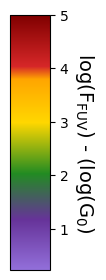

In [16]:
plotCmapFUV()

<ipython-input-19-906e0865e8f6>:24: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


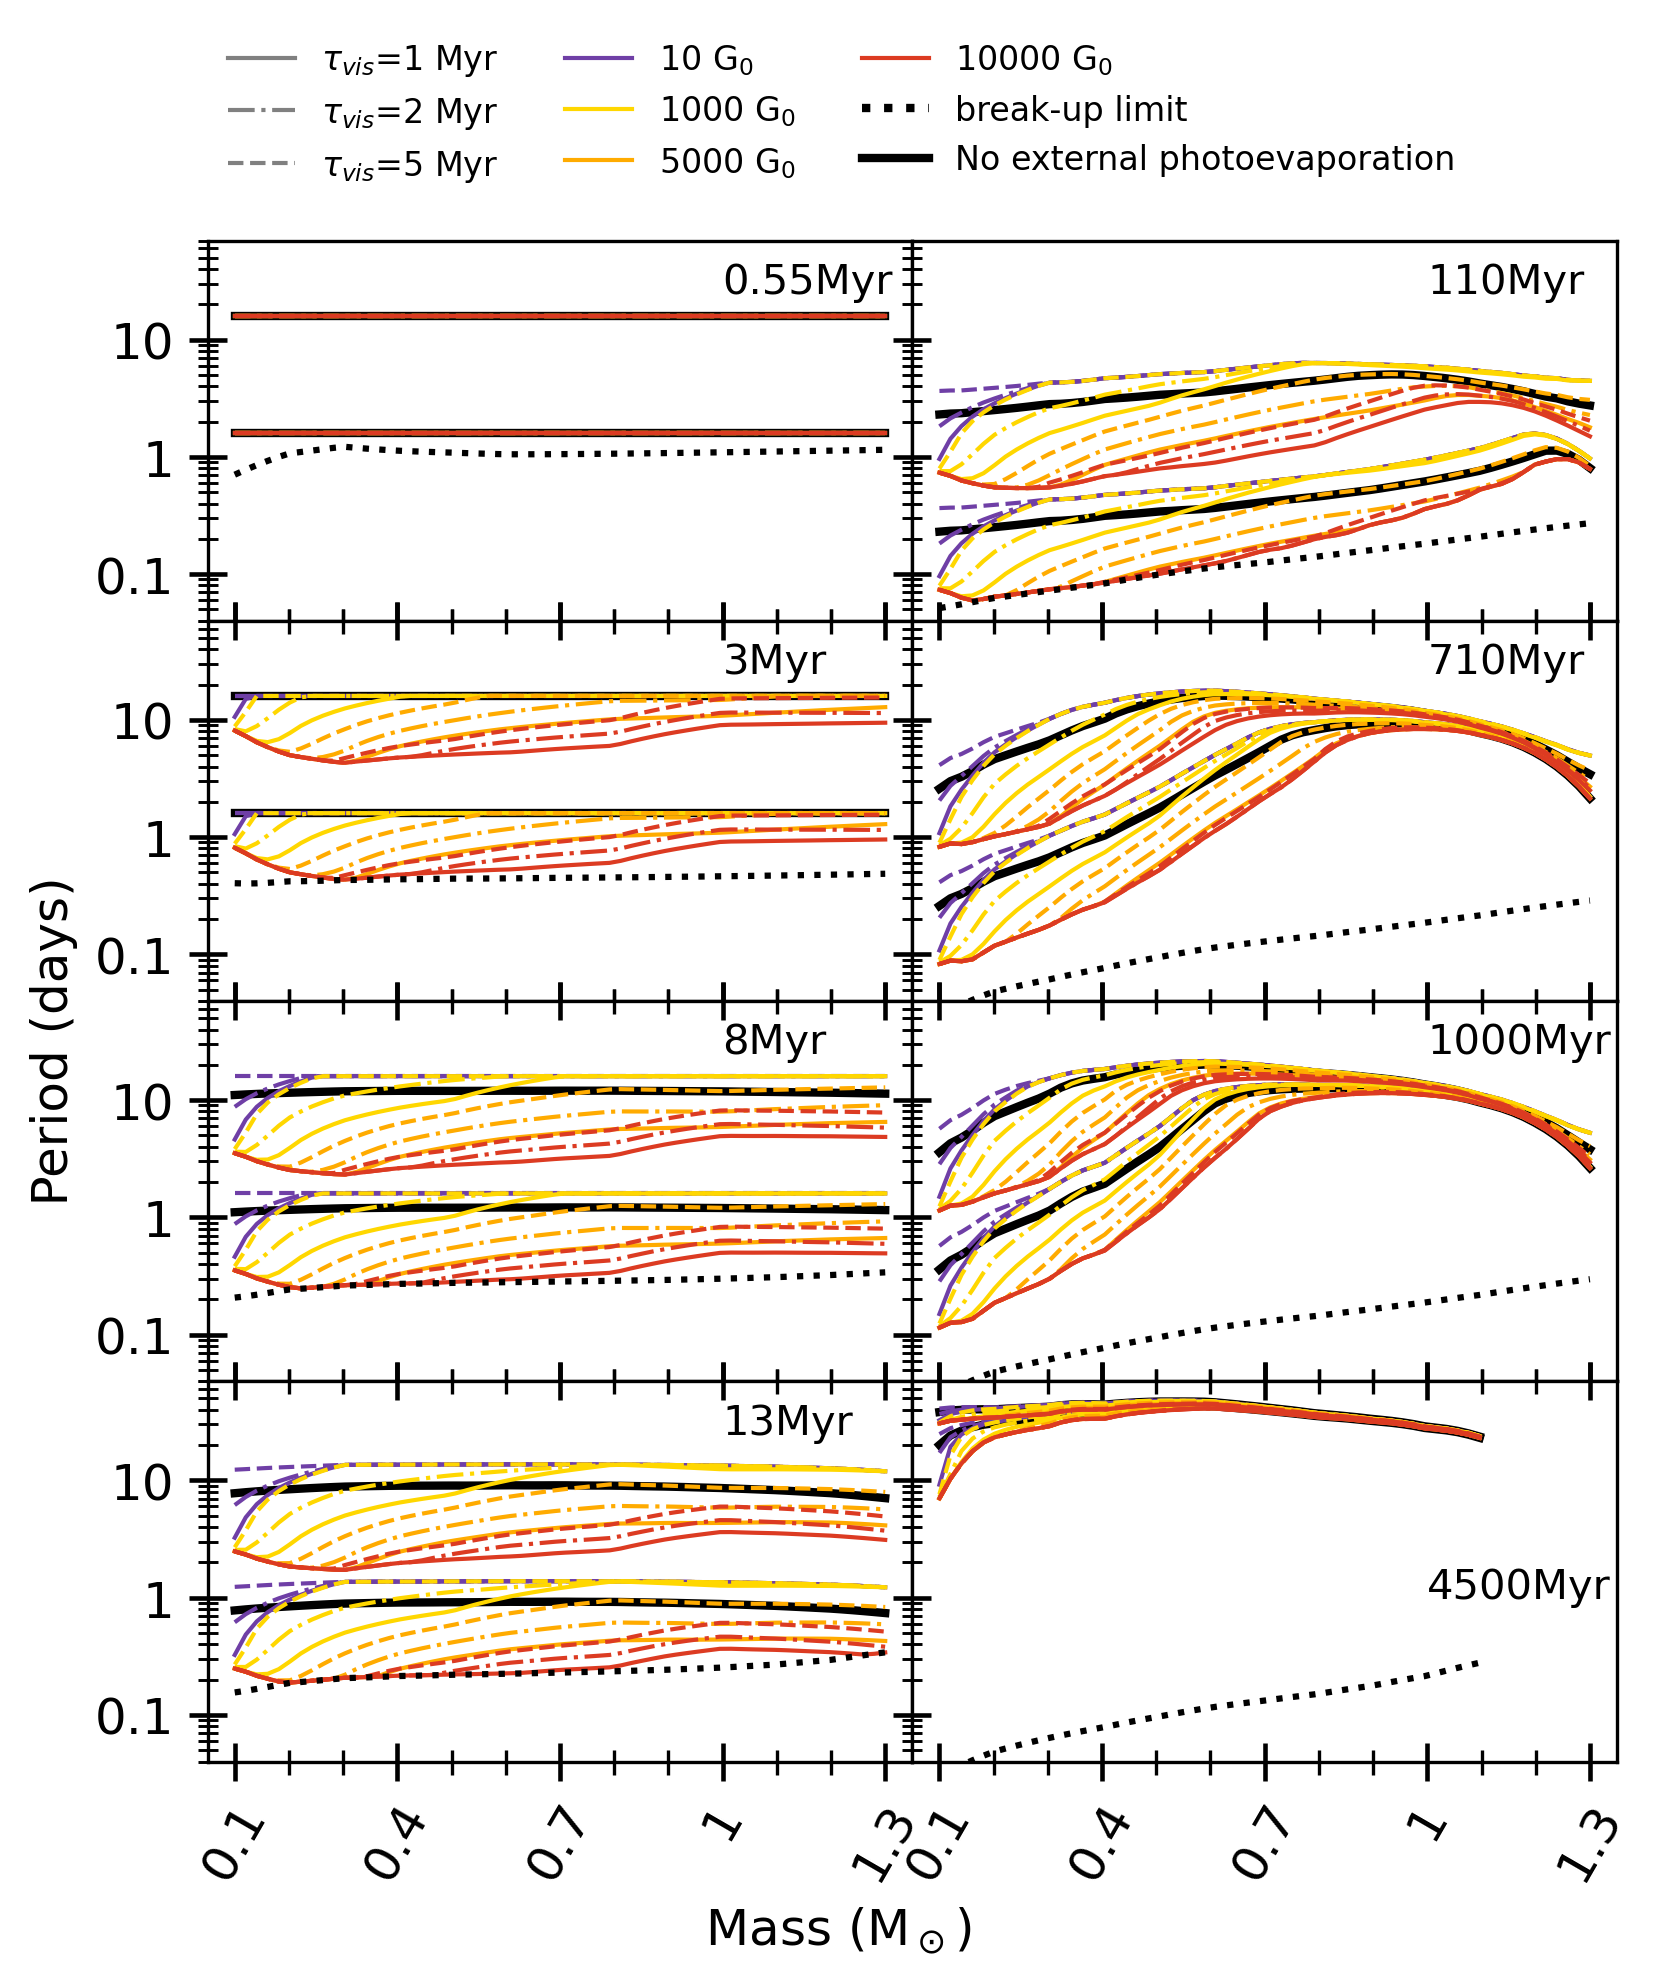

In [19]:
fig, axis = plt.subplots(4, 2, figsize=(5.4, 6.5), dpi=300, sharex=True, 
                         sharey=True)
plt.subplots_adjust(left=0.12, right=0.99, bottom=0.1, top=0.88)
plt.subplots_adjust(wspace=0., hspace=0)
axis_ = [(0,0), (1,0), (2,0), (3,0), (0,1), (1,1), (2,1), (3,1)]
fs = 12
x = []; z = []
lw = 1.5
alpha = 0.8
nn=0
# x=mass
mkr = ['o', 's', '^']
# sort=np.where(x<=1.3)[0]

axis[0, 0].plot([-10, -20], [-10, -20], '-', color='gray',lw=1, zorder=0,
                label=r'$\tau_{vis}$=1 Myr') 
axis[0, 0].plot([-10, -20], [-10, -20], '-.', color='gray', lw=1, zorder=0, 
                label=r'$\tau_{vis}$=2 Myr')
axis[0, 0].plot([-10, -20], [-10, -20], '--', color='gray', lw=1, zorder=0, 
                label=r'$\tau_{vis}$=5 Myr')

for i, t in enumerate(np.insert(time, 0, t0, axis=0)):
    ax = axis[axis_[i]]
    ax.set_yscale("log")  
    ax.set_ylim(0.04, 70)
    ax.set_xlim(0.05, 1.35)    
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([0.1, 1, 10]))       
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([0.2, 0.3, 0.5, 0.6, 
                                                        0.8, 0.9, 1.1, 1.2]))
    #set y ticks
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())         
    ax.tick_params(axis="y", which='minor', direction="inout", 
                       length=5, width=0.7)    
    ax.tick_params(axis="y", direction="inout", length=9, 
                       width=1.1)       
    ax.set_yticklabels([0.1, 1, 10], fontsize=fs)    
    if i == 2: 
        ax.set_ylabel(r'                   Period (days)', fontsize=fs)  
    #set x ticks
    if i not in [0, 4]:
        ax.tick_params(axis="x", which="minor", direction="inout", length=6, 
                   width=0.8, top=True) 
        ax.tick_params(axis="x", direction="inout", length=9, width=1.1, 
                       rotation=60, top=True)        
    else:
        ax.tick_params(axis="x", which="minor", direction="inout", length=6, 
                   width=0.8)            
        ax.tick_params(axis="x", direction="inout", length=9, width=1.1)
    if i in [3, 7]:
        ax.set_xticks([0.1, 0.4, 0.7, 1., 1.3])
        ax.set_xticklabels([0.1, 0.4, 0.7, 1, 1.3], fontsize=fs)
    if i == 3: 
        ax.set_xlabel(r'                                   Mass (M$_\odot$)',
                      fontsize=fs)         
    for FUV in disk.FUV:
        if FUV in [10,1000,5000,10000]:
            ax.plot(paper_isogyrochrones['1Myr']['slow'][str(int(FUV)) + \
                     'G0']['Mass'], paper_isogyrochrones['1Myr']['slow']\
                    [str(int(FUV)) + 'G0']['Period'][i], '-', 
                    label=r"{0} G$_0$".format(int(FUV)), 
                    color=cmapFUV(normFUV(np.log10(FUV))), lw=1)
            ax.plot(paper_isogyrochrones['1Myr']['fast'][str(int(FUV)) + \
                    'G0']['Mass'], paper_isogyrochrones['1Myr']['fast']\
                    [str(int(FUV))+'G0']['Period'][i], '-', 
                    color=cmapFUV(normFUV(np.log10(FUV))), lw=1)            
            for vis,ls in zip(['2Myr', '5Myr'],['-.', '--']):
                for speed in ['slow', 'fast']:
                    ax.plot(paper_isogyrochrones[vis][speed][str(int(FUV)) + \
                            'G0']['Mass'], paper_isogyrochrones[vis][speed]\
                            [str(int(FUV)) + 'G0']['Period'][i], ls, 
                            color=cmapFUV(normFUV(np.log10(FUV))), lw=1)
    if i == 0: 
        ax.text(1., 25, str(t/1e6) + 'Myr')
    elif i == 7: 
        ax.text(1., 1, str(int(t/1e6)) + 'Myr')
    else: 
        ax.text(1., 25, str(int(t/1e6)) + 'Myr')
    ax.plot(breakup[0], breakup[1][i], 'k:')    
    ax.set_xlim(0.05, 1.35)
    ax.plot(matt15['fast'][0], matt15['fast'][1][i], '-', color='k', zorder=0, 
            lw=2)
    ax.plot(matt15['slow'][0], matt15['slow'][1][i], '-', color='k', zorder=0, 
            lw=2)    
axis[0, 0].plot([-10, -20], [-10, -20], ':', color='k', lw=2, 
                label=r'break-up limit', zorder=0)
axis[0, 0].plot([-1, -2], [-1, -2], '-', color='k', lw=2, 
               label=r'No external photoevaporation')
leg = axis[0, 0].legend(ncol=3, fontsize=8, loc="upper center", 
                        bbox_to_anchor=(0.9, 1.6))
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')
plt.savefig(mydir + 'PeriodMassTracks_variousTauVis_1p6to16d.png') 

Figure 4 in the paper, following the [MNRSAS guidelines](https://academic.oup.com/mnras/pages/General_Instructions).

<ipython-input-178-e9108005f6e3>:24: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


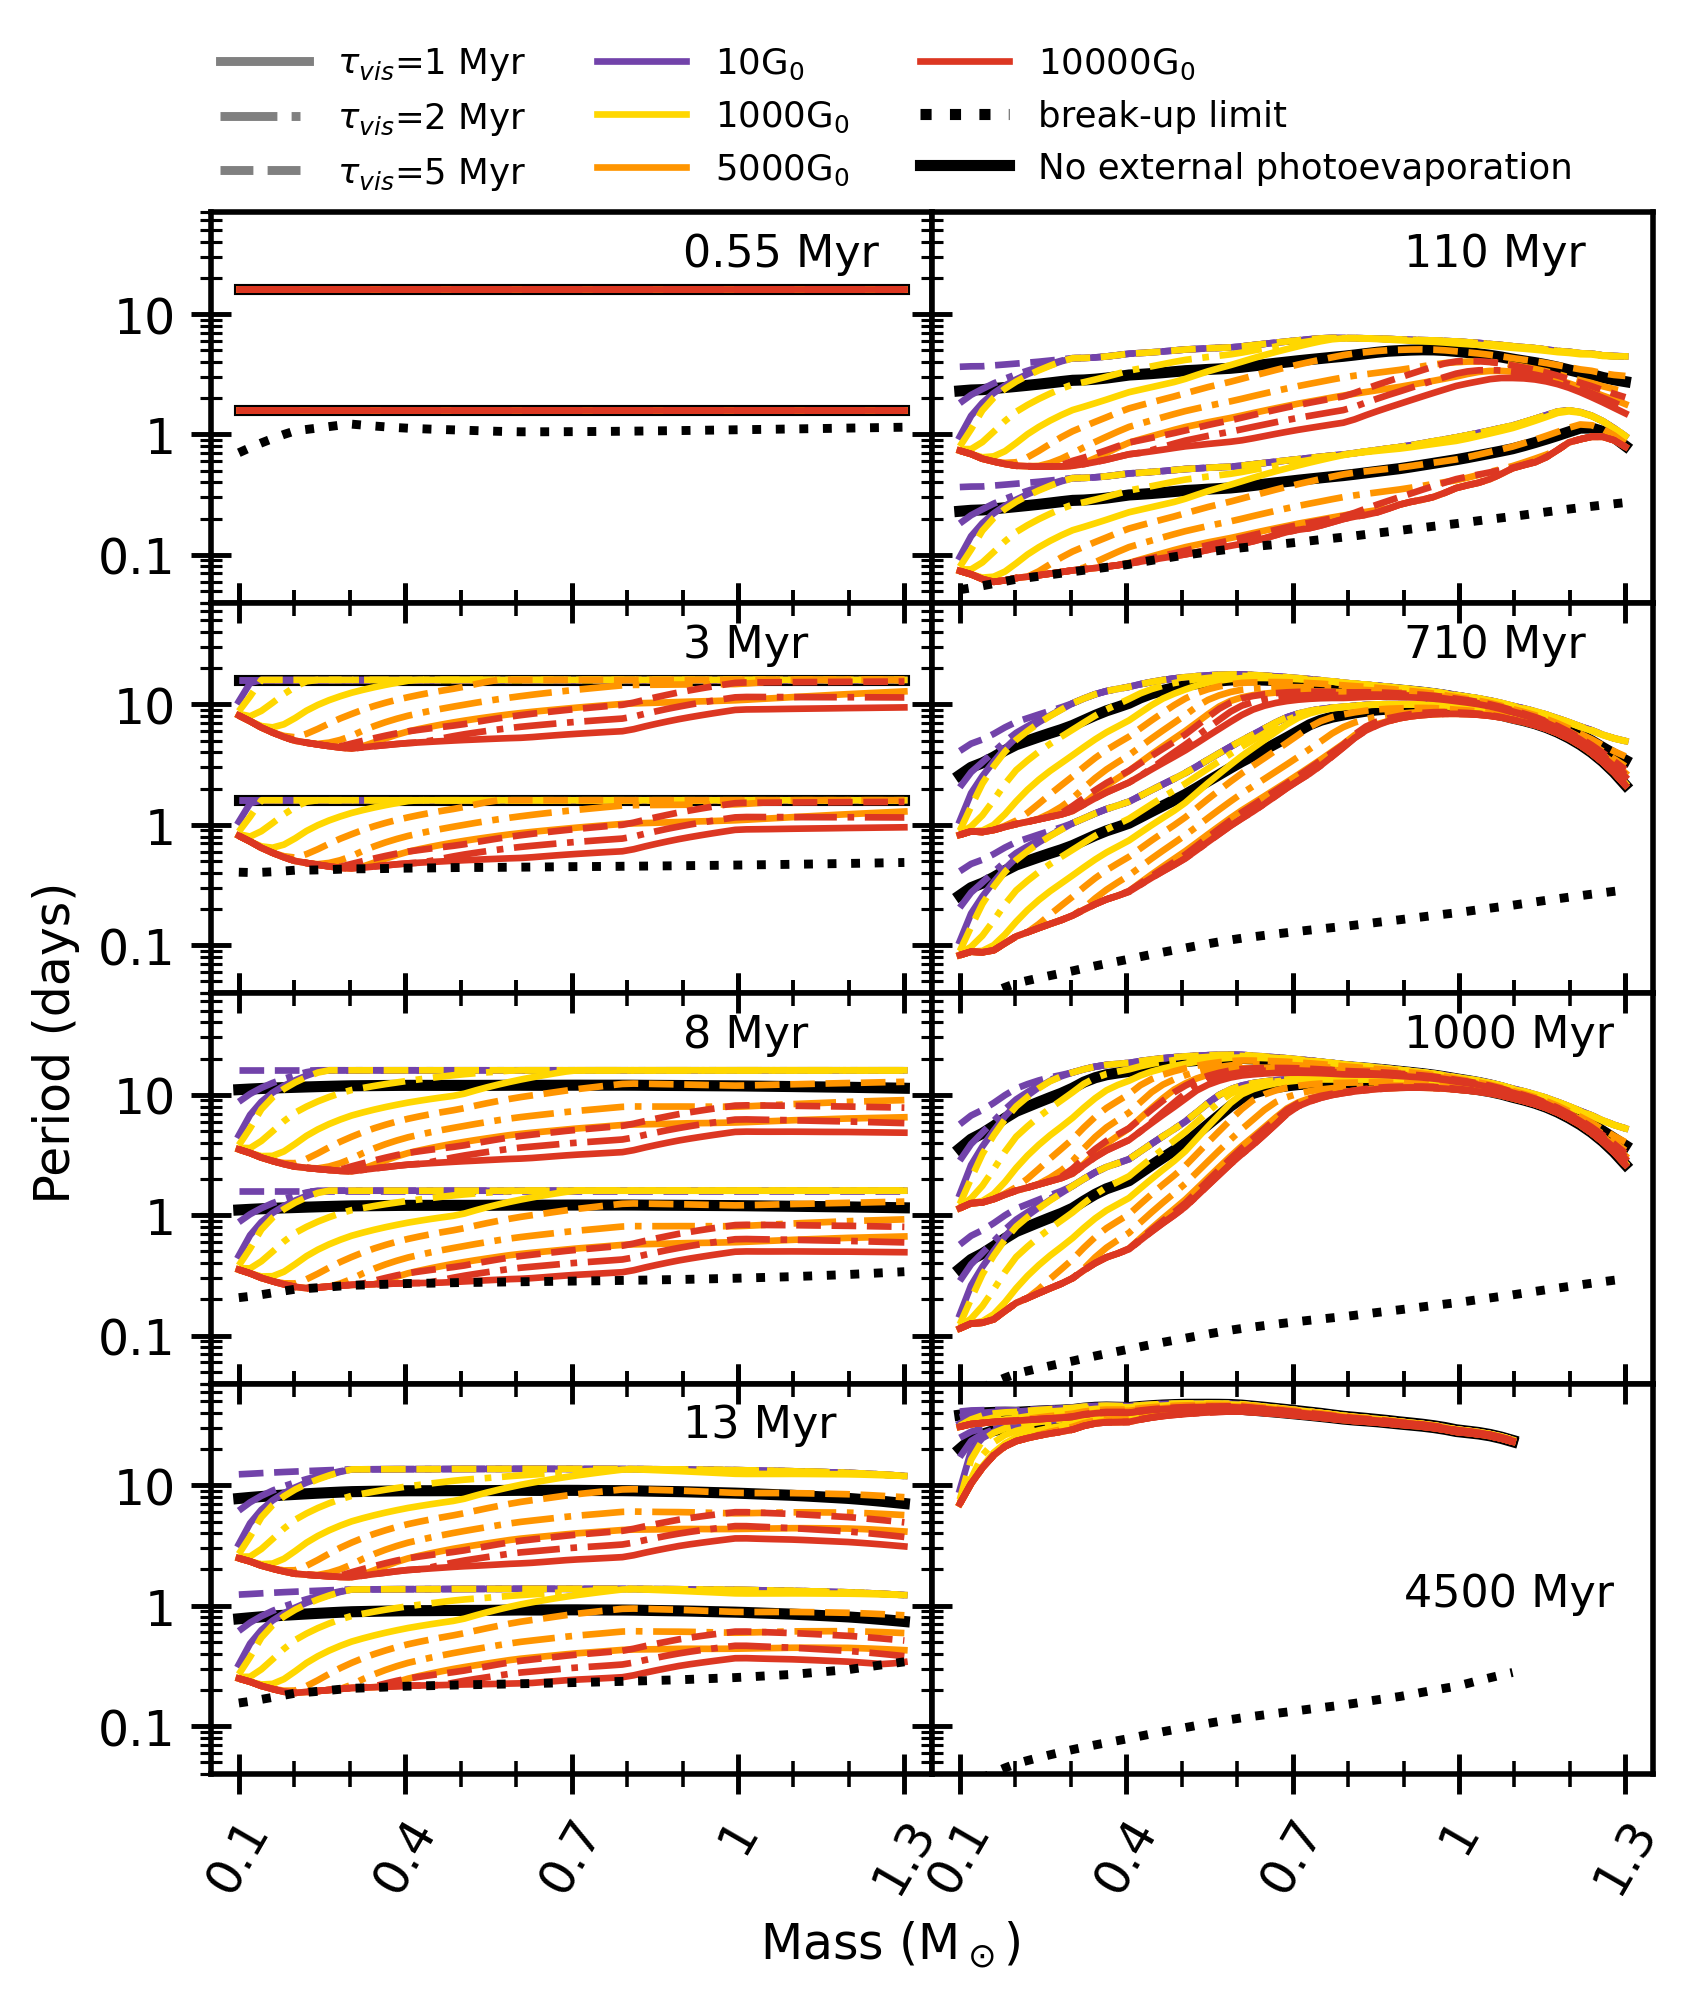

In [178]:
fig, axis = plt.subplots(4, 2, figsize=(5.15, 6.1), dpi=320, sharex=True, 
                         sharey=True)
plt.subplots_adjust(left=0.115, right=0.99, bottom=0.1, top=0.9)
plt.subplots_adjust(wspace=0., hspace=0)
axis_ = [(0,0), (1,0), (2,0), (3,0), (0,1), (1,1), (2,1), (3,1)]
fs = 11
x = []; z = []
lw = 1.5
alpha = 0.8
nn=0
# x=mass
mkr = ['o', 's', '^']
# sort=np.where(x<=1.3)[0]

axis[0, 0].plot([-10, -20], [-10, -20], '-', color='gray',lw=lw + 0.5, zorder=0,
                label=r'$\tau_{vis}$=1 Myr') 
axis[0, 0].plot([-10, -20], [-10, -20], '-.', color='gray', lw=lw + 0.5, zorder=0, 
                label=r'$\tau_{vis}$=2 Myr')
axis[0, 0].plot([-10, -20], [-10, -20], '--', color='gray', lw=lw + 0.5, zorder=0, 
                label=r'$\tau_{vis}$=5 Myr')

for i, t in enumerate(np.insert(time, 0, t0, axis=0)):
    ax = axis[axis_[i]]
    ax.set_yscale("log")  
    ax.set_ylim(0.04, 70)
    ax.set_xlim(0.05, 1.35)    
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([0.1, 1, 10]))       
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([0.2, 0.3, 0.5, 0.6, 
                                                        0.8, 0.9, 1.1, 1.2]))
    #set y ticks
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())         
    ax.tick_params(axis="y", which='minor', direction="inout", 
                       length=5, width=0.7)    
    ax.tick_params(axis="y", direction="inout", length=9, 
                       width=1.1)       
    ax.set_yticklabels([0.1, 1, 10], fontsize=fs)    
    if i == 2: 
        ax.set_ylabel(r'                   Period (days)', fontsize=fs)  
    #set x ticks
    if i not in [0, 4]:
        ax.tick_params(axis="x", which="minor", direction="inout", length=6, 
                   width=0.8, top=True) 
        ax.tick_params(axis="x", direction="inout", length=9, width=1.1, 
                       rotation=60, top=True)        
    else:
        ax.tick_params(axis="x", which="minor", direction="inout", length=6, 
                   width=0.8)            
        ax.tick_params(axis="x", direction="inout", length=9, width=1.1)
    if i in [3, 7]:
        ax.set_xticks([0.1, 0.4, 0.7, 1., 1.3])
        ax.set_xticklabels([0.1, 0.4, 0.7, 1, 1.3], fontsize=fs)
    if i == 3: 
        ax.set_xlabel(r'                                         Mass (M$_\odot$)',
                      fontsize=fs)         
    for FUV in disk.FUV:
        if FUV in [10,1000,5000,10000]:
            ax.plot(paper_isogyrochrones['1Myr']['slow'][str(int(FUV)) + \
                     'G0']['Mass'], paper_isogyrochrones['1Myr']['slow']\
                    [str(int(FUV)) + 'G0']['Period'][i], '-', 
                    label=r"{0}G$_0$".format(int(FUV)), 
                    color=cmapFUV(normFUV(np.log10(FUV))), lw=lw)
            ax.plot(paper_isogyrochrones['1Myr']['fast'][str(int(FUV)) + \
                    'G0']['Mass'], paper_isogyrochrones['1Myr']['fast']\
                    [str(int(FUV))+'G0']['Period'][i], '-', 
                    color=cmapFUV(normFUV(np.log10(FUV))), lw=lw)            
            for vis,ls in zip(['2Myr', '5Myr'],['-.', '--']):
                for speed in ['slow', 'fast']:
                    ax.plot(paper_isogyrochrones[vis][speed][str(int(FUV)) + \
                            'G0']['Mass'], paper_isogyrochrones[vis][speed]\
                            [str(int(FUV)) + 'G0']['Period'][i], ls, 
                            color=cmapFUV(normFUV(np.log10(FUV))), lw=lw)
    if i == 0: 
        ax.text(0.9, 25, str(t/1e6) + ' Myr')
    elif i == 7: 
        ax.text(.9, 1, str(int(t/1e6)) + ' Myr')
    else: 
        ax.text(.9, 25, str(int(t/1e6)) + ' Myr')
    ax.plot(breakup[0], breakup[1][i],'k:', lw=lw + 0.5)    
    ax.set_xlim(0.05, 1.35)
    ax.plot(matt15['fast'][0], matt15['fast'][1][i], '-', color='k', zorder=0,
            lw=lw + 1)
    ax.plot(matt15['slow'][0], matt15['slow'][1][i], '-', color='k', zorder=0, 
            lw=lw + 1)    
    for ix in ['top', 'bottom', 'left', 'right']:
        ax.spines[ix].set_linewidth(1.25)
axis[0, 0].plot([-10, -20], [-10, -20], ':', color='k', lw=lw + 1, 
                label=r'break-up limit', zorder=0)
axis[0, 0].plot([-1, -2], [-1, -2], '-', color='k', lw=lw + 1, 
               label=r'No external photoevaporation')
leg = axis[0, 0].legend(handlelength=2.5, ncol=3, fontsize=8, loc="upper center", 
                        bbox_to_anchor=(0.95, 1.51))
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')
plt.savefig(mydir + 'PeriodMassTracks_variousTauVis_1p6to16d.pdf') 

## Observed datasets plot:

This function in `ObservedDatasets` estimates de rolling percentiles of a period-mass distribution. This was used in the paper to estimate the moving average and the fast- and slow-rotating envelopes of the distributions.  

```python
def PeriodMass_RollingPercentile(x, y, percentile, window_size=0.14, 
                                 secondary_window_size=0.05, min_data=12, 
                                 secondary_min_data=4):
    """
    Estimates the rolling percentile of a period mass distribution

    ----
    
    INPUT:
        x:                      mass
        y:                      periods
        percentile:            [0.,1.] desired percentile
        window_size:           [0.,1.] percentage of the total amount of 
                               datapoints  to be used as window size for 
                               estimating the rolling statistics
        secondary_window_size: secondary window size for calculating rolling 
                               statistics at higher masses, where typically 
                               there are less datapoints available
        min_data:              minimum datapoints to be used for calculating 
                               the rolling statistics close to the extremity
        secondary_min_data:    same as min_data, but for the portion of the 
                               distrbution at higher masses
    ----
    OUTPUT:
        returns a curve of estimated percentiles at each x
         x_: masses - it's effectivelly the same as x, but ordered for 
             ascending masses
         out: periods - percentile at each point
    """
    valid = np.isfinite(x) & np.isfinite(y)
    x = np.array(x[valid])
    y = np.array(y[valid])
    sort_ = np.argsort(x)
    x_ = x[sort_]
    out=np.full((len(x)),np.nan)
    series = pd.Series(y[sort_])
    wd = int(window_size*len(x_))
    wd_ = int(secondary_window_size*len(x_))
    out[:-wd] = series.rolling(window=wd, min_periods=min_data).quantile\
                (percentile, interpolation='lower').values[:-wd]
    out[-wd:] = series.rolling(window=wd_, min_periods=secondary_min_data)\
              .quantile(percentile, interpolation='higher').values[-wd:]
    return x_, out
```

In [19]:
from FIREstars.ObservedDatasets import PeriodMass_RollingPercentile

This additional function allows me to plot it inside a period-mass diagram. 

In [115]:
def plot_percentiles(ax, x, y, percentile=[.05, 0.5, 0.95], window_size=0.14, 
                     secondary_window_size=0.05, min_data=12, 
                     secondary_min_data=4, zorder=0, lw=1.5, ms=2, 
                     mkr=['o','s','^'], color='k', ec='k', alpha=0.8,
                     ls='-', dash=(5,1)):
    for c,qt in enumerate(percentile):
        xp, yp = PeriodMass_RollingPercentile(x, y, qt)        
        ax.plot(xp, yp, linestyle=ls, color=color, mfc='none', zorder=zorder, 
                lw=lw, alpha=alpha, dashes=dash)
        if ec == 'none':
            pass
        else:
            for m in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3]:
                ii = np.argsort(abs(xp - m))[0]
                ax.plot(xp[ii], yp[ii], mkr[c], color=color, ms=ms, zorder=zorder,
                        markeredgecolor=ec)  


The `ObservedDatasets` package also includes classes for reading the datasets showed in the paper. The masses were estimated as described in Appendix A of Roquette+2021. 

In [21]:
import FIREstars.ObservedDatasets as obs

In [22]:
ngc2264 = obs.NGC2264()
ngc2264_M = ngc2264.Mass
ngc2264_P = ngc2264.Prot
print(ngc2264.Mass.shape, ngc2264.Mass.max(), ngc2264.Mass.min())

Loading data, RA, Dec, Prot, Mass, SpT, Av, Disk
Period adopted from Venuti+17, or Lamm+05 otherwise
(522,) 1.398720177599091 0.014529948031708956


In [23]:
usco = obs.USco()
usco_M = usco.Mass
usco_P = usco.Prot
print(usco.Mass.shape, usco.Mass.max(), usco.Mass.min())

Loading data,RA,Dec,Prot,Mass,EBV,Disk
(872,) 1.3955568657067827 0.006467132922713281


In [24]:
hPer = obs.hPer()
hPer_M = hPer.Mass
hPer_P = hPer.Prot
print(hPer.Mass.shape, hPer.Mass.max(), hPer.Mass.min())

Loading data,RA,Dec,Prot,Mass,Amp,SpT,EBV
Binary stars were removed following the flags in Moraux+2013
(418,) 1.3977720100203568 0.21469573786233376


In [25]:
praesepe = obs.Praesepe()
praesepe_M = praesepe.Mass
praesepe_P = praesepe.Prot
print(praesepe.Mass.shape, praesepe.Mass.max(), praesepe.Mass.min())

Loading data,RA,Dec,Prot,Mass
(771,) 1.3998248824003827 0.13153156833120128


In [26]:
pleiades = obs.Pleiades()
pleiades_M = pleiades.Mass
pleiades_P = pleiades.Prot
print(pleiades.Mass.shape, pleiades.Mass.max(), pleiades.Mass.min())

Loading data,RA,Dec,Prot,Mass,Amp
(735,) 1.3607749926652364 0.08424897375966478


In [27]:
ngc6811 = obs.NGC6811()
ngc6811_M = ngc6811.Mass
ngc6811_P = ngc6811.Prot
print(ngc6811.Mass.shape, ngc6811.Mass.max(), ngc6811.Mass.min())

Loading data,RA,Dec,Prot,Mass,Amp
(166,) 1.3759015989237198 0.5442760350974902


In [28]:
Mass = [ngc2264_M, usco_M, hPer_M, pleiades_M, praesepe_M, ngc6811_M]
Period = [ngc2264_P, usco_P, hPer_P, pleiades_P, praesepe_P, ngc6811_P]
cluster_name = ['NGC 2264', 'Upper Sco', 'h Per', 'Pleiades', 'Praesepe',
                'NGC 6811']

This plot below is Fig. 1 in the Roquette+21 paper, already in the MNRAS requirements.

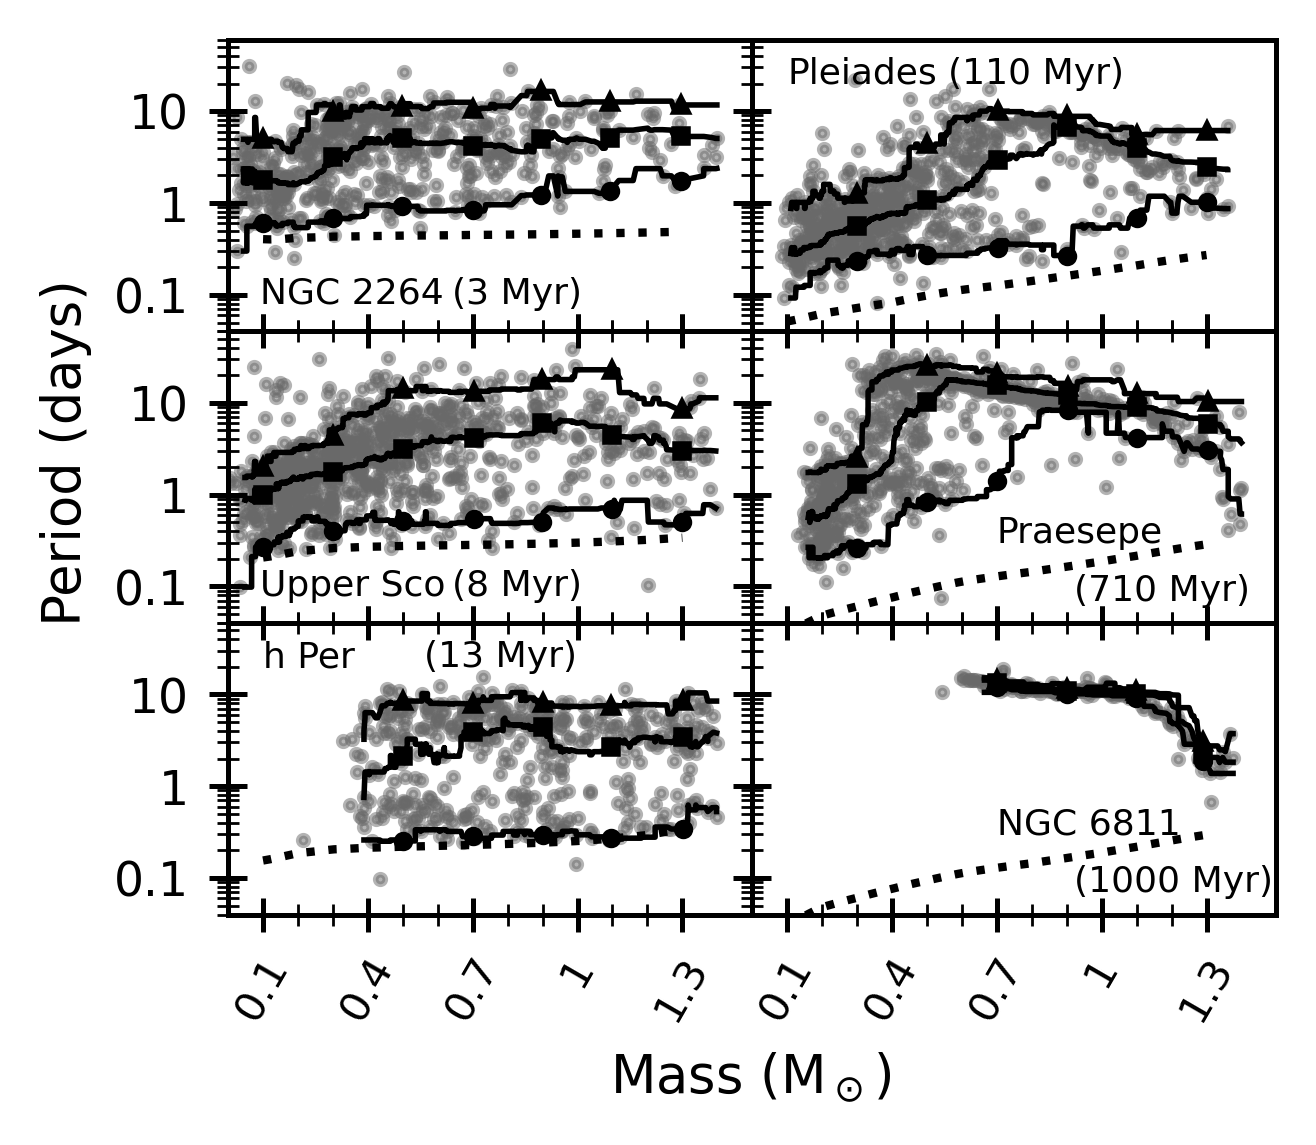

In [29]:
fig, axis = plt.subplots(3, 2, figsize=(3.15, 2.7), dpi=400, sharex=True, 
                         sharey=True)
plt.subplots_adjust(left=0.158, right=0.99, bottom=0.18, top=0.99)
plt.subplots_adjust(wspace=0., hspace=0)
axis_ = [(0,0), (1,0), (2,0), (0,1), (1,1), (2,1)]
fs = 9.5
x = []; z = []
lw = 1
s = 3
alpha = 0.8
nn=0
# x=mass
mkr = ['o', 's', '^']
# sort=np.where(x<=1.3)[0]


for i, t in enumerate(time[:-1]):
    ax = axis[axis_[i]]
    ax.set_yscale("log")  
    ax.set_ylim(0.04,60)
    ax.set_xlim(0.0,1.5)    
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([0.1, 1, 10]))       
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([0.2, 0.3, 0.5, 0.6, 
                                                        0.8, 0.9, 1.1, 1.2]))
    #set y ticks
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())         
    ax.tick_params(axis="y", which='minor', direction="inout", 
                       length=4, width=0.5)    
    ax.tick_params(axis="y", direction="inout", length=7, 
                       width=0.9)       
    ax.set_yticklabels([0.1, 1, 10], fontsize=fs - 1)    
    if i == 1: 
        ax.set_ylabel(r'   Period (days)', fontsize=fs)  
    #set x ticks
    if i not in [0, 3]:
        ax.tick_params(axis="x", which="minor", direction="inout", length=4, 
                   width=0.5, top=True) 
        ax.tick_params(axis="x", direction="inout", length=6, width=0.9, 
                       rotation=60, top=True)        
    else:
        ax.tick_params(axis="x", which="minor", direction="inout", length=4, 
                   width=0.5)            
        ax.tick_params(axis="x", direction="inout", length=6, width=0.9)
    if i in [2, 5]:
        ax.set_xticks([0.1, 0.4, 0.7, 1., 1.3])
        ax.set_xticklabels([0.1, 0.4, 0.7, 1, 1.3], fontsize=fs - 2)
    if i == 2: 
        ax.set_xlabel(r'                               Mass (M$_\odot$)',
                      fontsize=fs)         
    if i in [0 ,1]: 
        ax.text(.64, .08, '(' + str(int(t/1e6)) + ' Myr)', fontsize=fs - 3.)
        ax.text(.09, .08, cluster_name[i], fontsize=fs - 3.)  
    elif i in [4, 5]: 
        ax.text(0.92, .07,'(' + str(int(t/1e6)) + ' Myr)', fontsize=fs - 3.)
        ax.text(0.7, .3, cluster_name[i], fontsize=fs - 3.)          
    else: 
        ax.text(.56, 20, '(' + str(int(t/1e6)) + ' Myr)', fontsize=fs - 3.)
        ax.text(.1, 20, cluster_name[i], fontsize=fs - 3.)   

    ax.plot(breakup[0],breakup[1][i+1],'k:',)    
    # plot cluster data
    x = Mass[i]
    y = Period[i]
    mass_range_ = np.where((x >= 0.0) & (x <= 1.4))[0]
    x = x[mass_range_]
    y = y[mass_range_]    
    a = ax.scatter(x, y, s=s, c='dimgray', alpha=0.5, zorder=0)
    plot_percentiles(ax, x, y, percentile=[.05, 0.5, 0.95], window_size=0.14,
            secondary_window_size=0.05, min_data=10, secondary_min_data=4,
                     ms=2.5, lw=1)

    for ix in ['top','bottom','left','right']:
        ax.spines[ix].set_linewidth(0.9)
plt.savefig(mydir + 'Observational_periodmass_withpercentile.pdf')    

As a request from the referee, the new Figure 1 below includes extra panels comparing the statistical properties of clusters at different ages. The colors were chosen while avoiding the colors in the FUV-color map.

<ipython-input-128-4f9eda696f3c>:36: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


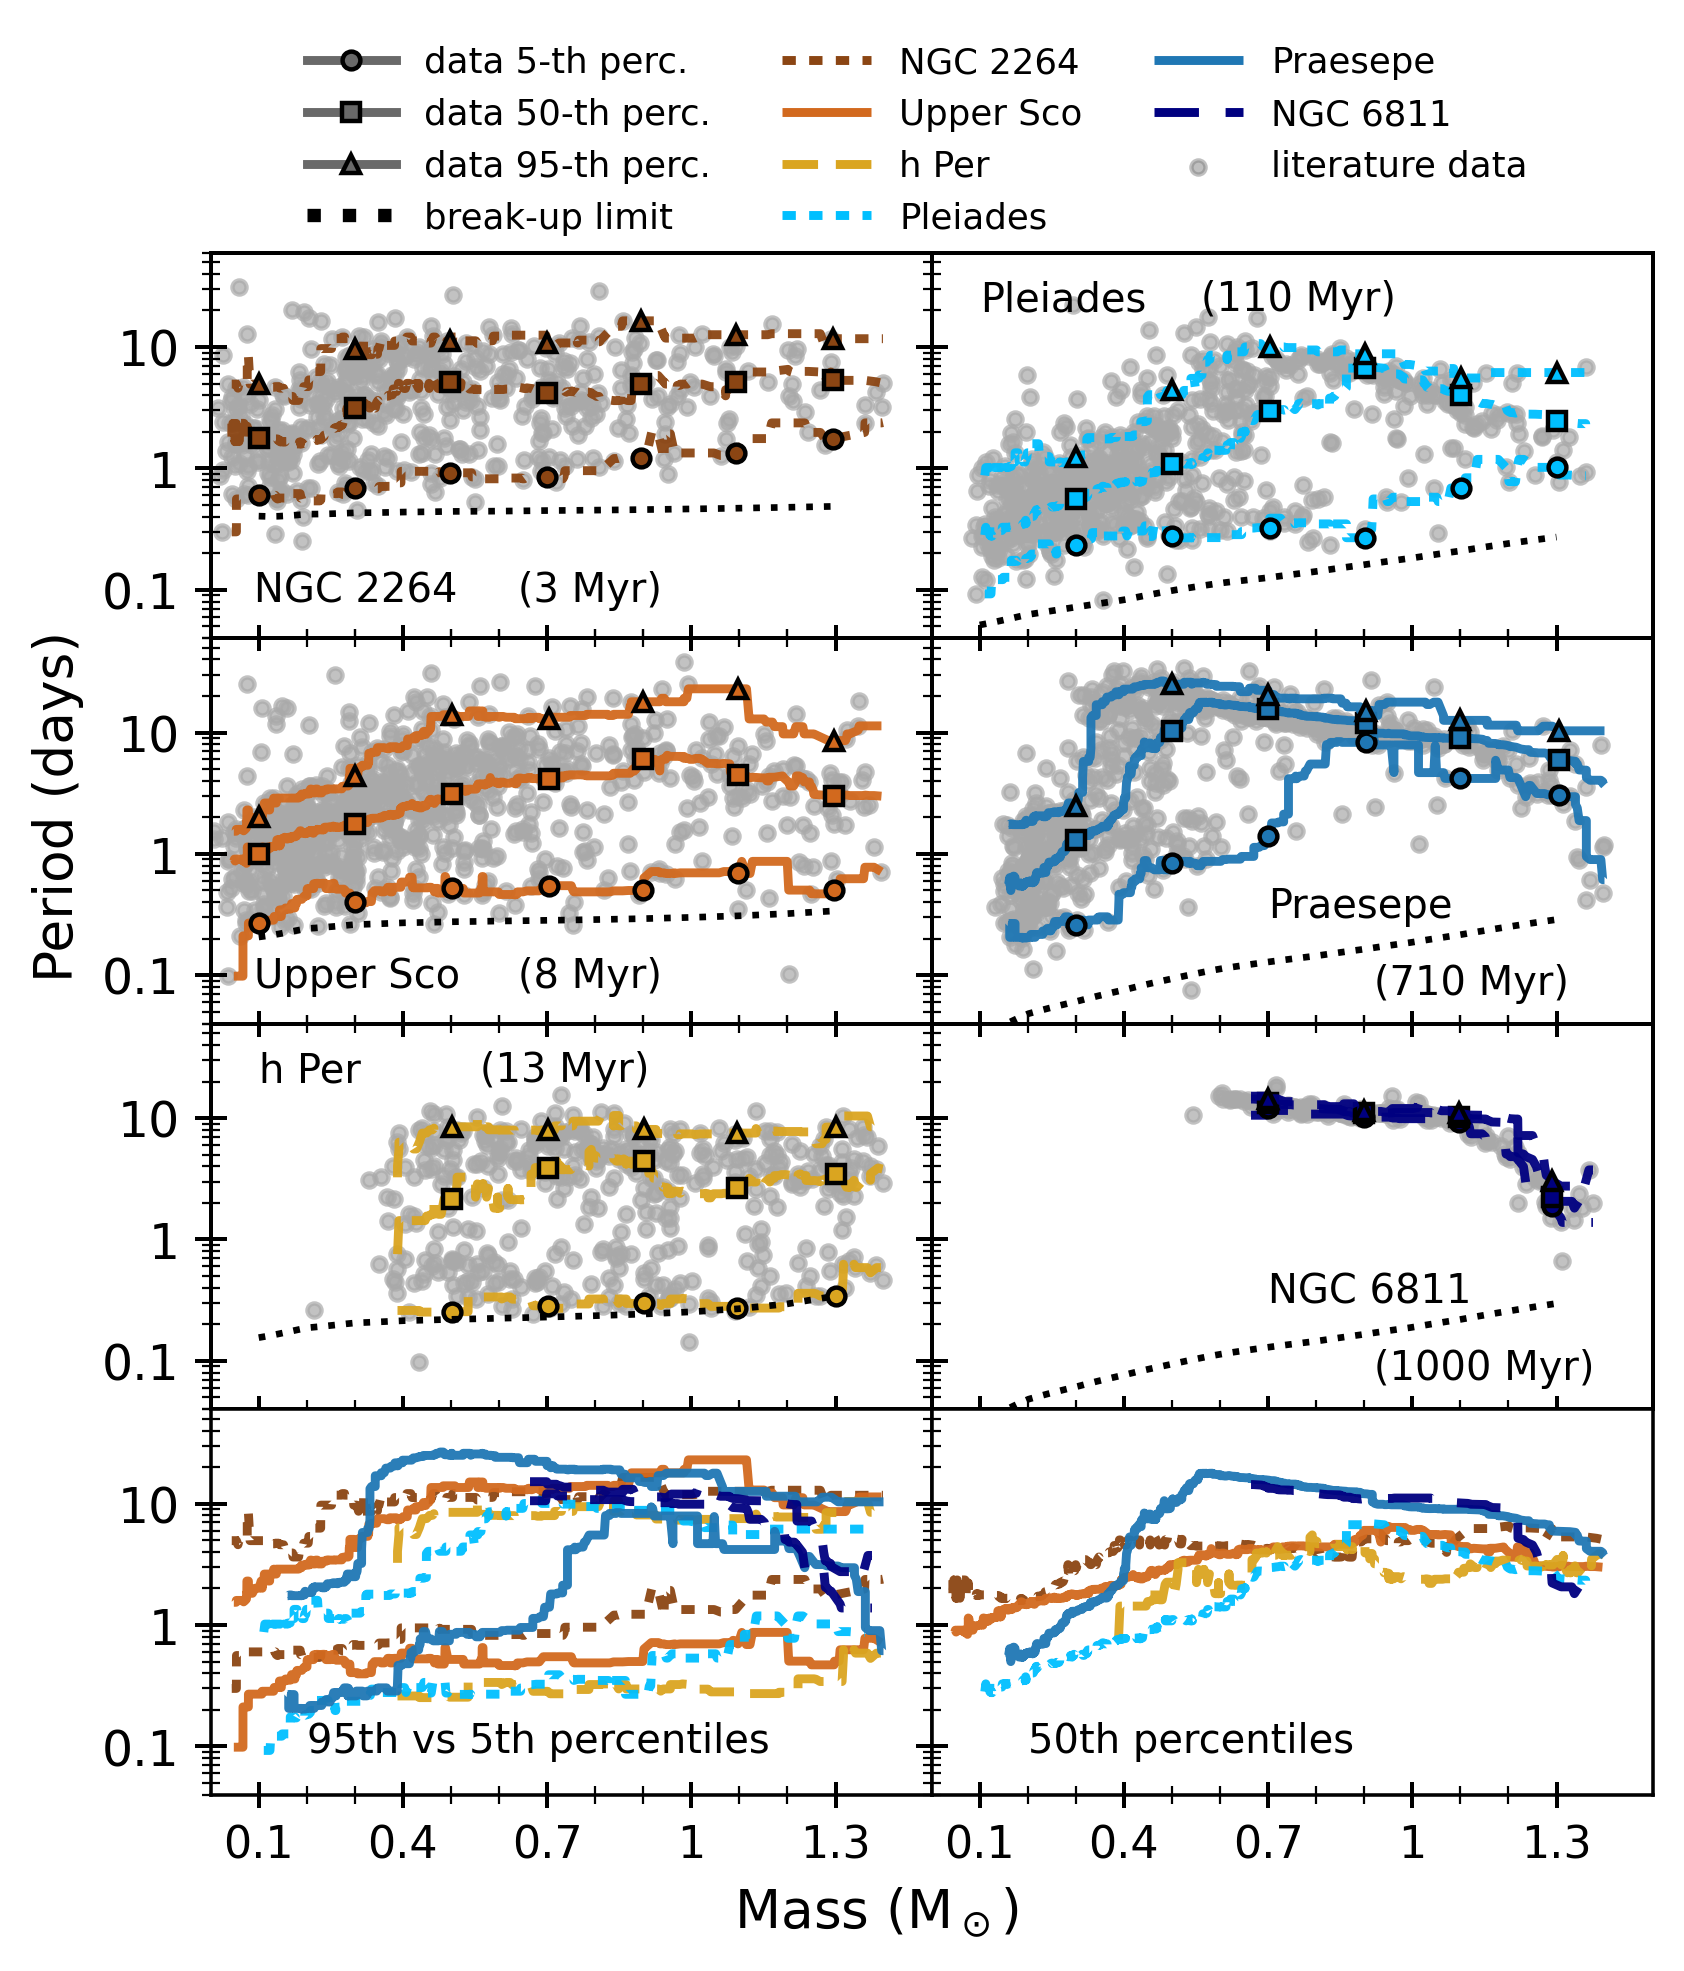

In [128]:
fig, axis = plt.subplots(4, 2, figsize=(5.15, 6.1), dpi=320, sharex=True, 
                         sharey=True)
plt.subplots_adjust(left=0.115, right=0.99, bottom=0.08, top=0.87)
plt.subplots_adjust(wspace=0., hspace=0)
axis_ = [(0,0), (1,0), (2,0), (0,1), (1,1), (2,1)]
ax_bl = axis[3,0]
ax_br = axis[3,1]

fs = 12
x = []; z = []
lw = 2
alpha = 0.8
nn = 0
s = 10
ms=4
mkr = ['o', 's', '^']
ls = [ '-.', '-', '--', ':', '-.', '-']
dashes=[(1.5, 1.5), (1, 0), (4, 2), (1.5, 1.5), (1, 0), (5, 3)]
colors = ['saddlebrown', 'chocolate', 'goldenrod', 'deepskyblue', 'tab:blue',
           'navy']

for c, qt in enumerate([0.05, 0.5, .95]):
    axis[0, 0].plot([-1, -1.1], [-1., -1.1], mkr[c], ms=4, color='dimgray', label=
                    'data ' + str(int(100*qt)) + '-th perc.', linestyle='-',
                    lw=lw, markeredgecolor='k')
axis[0, 0].plot([-10, -20], [-10, -20], ':', color='k', lw=lw + 1, 
                label=r'break-up limit', zorder=0)
axis[0, 0].scatter(-1, -1, s=s, c='gray', alpha=0.5, 
                   label='literature data')    
for i in range(6):
    axis[0, 0].plot([1000, 100000], [-1., -1.1], ls[i], dashes=dashes[i], 
                    color=colors[i], label=cluster_name[i], lw=lw, zorder=21)
    
for i, t in enumerate(time[:-1]):
    ax = axis[axis_[i]]
    ax.set_yscale("log")  
    ax.set_ylim(0.04,60)
    ax.set_xlim(0.0,1.5)    
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([0.1, 1, 10]))       
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([0.2, 0.3, 0.5, 0.6, 
                                                        0.8, 0.9, 1.1, 1.2]))
    #set y ticks
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())         
    ax.tick_params(axis="y", which='minor', direction="inout", 
                       length=4, width=0.5)    
    ax.tick_params(axis="y", direction="inout", length=7, 
                       width=0.9)       
    ax.set_yticklabels([0.1, 1, 10], fontsize=fs - 1)    
    if i == 1: 
        ax.set_ylabel(r'   Period (days)', fontsize=fs)  
    #set x ticks
    if i not in [0, 3]:
        ax.tick_params(axis="x", which="minor", direction="inout", length=4, 
                   width=0.5, top=True) 
        ax.tick_params(axis="x", direction="inout", length=6, width=0.9, 
                       rotation=60, top=True)        
    else:
        ax.tick_params(axis="x", which="minor", direction="inout", length=4, 
                   width=0.5)            
        ax.tick_params(axis="x", direction="inout", length=6, width=0.9)
    if i in [2, 5]:
        ax.set_xticks([0.1, 0.4, 0.7, 1., 1.3])
        ax.set_xticklabels([0.1, 0.4, 0.7, 1, 1.3], fontsize=fs - 2)     
    if i in [0 ,1]: 
        ax.text(.64, .08, '(' + str(int(t/1e6)) + ' Myr)', fontsize=fs - 3.)
        ax.text(.09, .08, cluster_name[i], fontsize=fs - 3.)  
    elif i in [4, 5]: 
        ax.text(0.92, .07,'(' + str(int(t/1e6)) + ' Myr)', fontsize=fs - 3.)
        ax.text(0.7, .3, cluster_name[i], fontsize=fs - 3.)          
    else: 
        ax.text(.56, 20, '(' + str(int(t/1e6)) + ' Myr)', fontsize=fs - 3.)
        ax.text(.1, 20, cluster_name[i], fontsize=fs - 3.)    

    ax.plot(breakup[0],breakup[1][i+1],'k:',)    
    # plot cluster data
    x = Mass[i]
    y = Period[i]
    mass_range_ = np.where((x >= 0.0) & (x <= 1.4))[0]
    x = x[mass_range_]
    y = y[mass_range_]    
    a = ax.scatter(x, y, s=s, c='darkgray', alpha=0.7, zorder=0)
    plot_percentiles(ax, x, y, percentile=[.05, 0.5, 0.95], window_size=0.14,
            secondary_window_size=0.05, min_data=10, secondary_min_data=4,
                     ms=ms, lw=lw, color=colors[i], alpha=0.95, ls=ls[i], 
                     dash=dashes[i])
    plot_percentiles(ax_bl, x, y, percentile=[.05, 0.95], window_size=0.14,
            secondary_window_size=0.05, min_data=10, secondary_min_data=4,
                     ms=ms, lw=lw, color=colors[i], ec='none', alpha=0.95, 
                     ls=ls[i], dash=dashes[i])    

    plot_percentiles(ax_br, x, y, percentile=[.5], window_size=0.14,
            secondary_window_size=0.05, min_data=10, secondary_min_data=4,
                     ms=ms, lw=lw, color=colors[i], ec='none', alpha=0.95, 
                     ls=ls[i], dash=dashes[i])    
    
    for ix in ['top','bottom','left','right']:
        ax.spines[ix].set_linewidth(0.9)

leg = axis[0, 0].legend(handlelength=2.5, ncol=3, fontsize=8, loc="upper center", 
                        bbox_to_anchor=(0.98, 1.62))
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')        


ax_bl.set_xlabel(r'                                    Mass (M$_\odot$)',
                      fontsize=fs)    

ax_bl.text(.2, 0.09, '95th vs 5th percentiles', fontsize=fs - 3.)    
ax_br.text(.2, 0.09, '50th percentiles', fontsize=fs - 3.)    

for ax in {ax_bl, ax_br}:
    ax.tick_params(axis="x", which="minor", direction="inout", length=4, 
                   width=0.5)            
    ax.tick_params(axis="x", direction="inout", length=6, width=0.9)
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([0.1, 1, 10]))       
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([0.2, 0.3, 0.5, 0.6, 
                                                        0.8, 0.9, 1.1, 1.2]))
    #set y ticks
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())         
    ax.tick_params(axis="y", which='minor', direction="inout", 
                       length=4, width=0.5)    
    ax.tick_params(axis="y", direction="inout", length=7, 
                       width=0.9)       
    ax.set_yticklabels([0.1, 1, 10], fontsize=fs - 1)    
    ax.set_ylim(0.04,60)
    ax.set_xlim(0.0,1.5)        

savedir = '/Users/jroquette/work/plot/'
plt.savefig(savedir + 'Observational_periodmass_with_1Myr_tauvis_zoom_referee.pdf')    

## Observed datasets with isogyrochrones

Finally, this plot below is Fig. 5 in the paper. Here, because the goal was to compare the rolling percentiles with the isogyrochrones, I am only plotting the 95th and 5th rolling percentiles. 

<ipython-input-63-f382d16ad473>:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


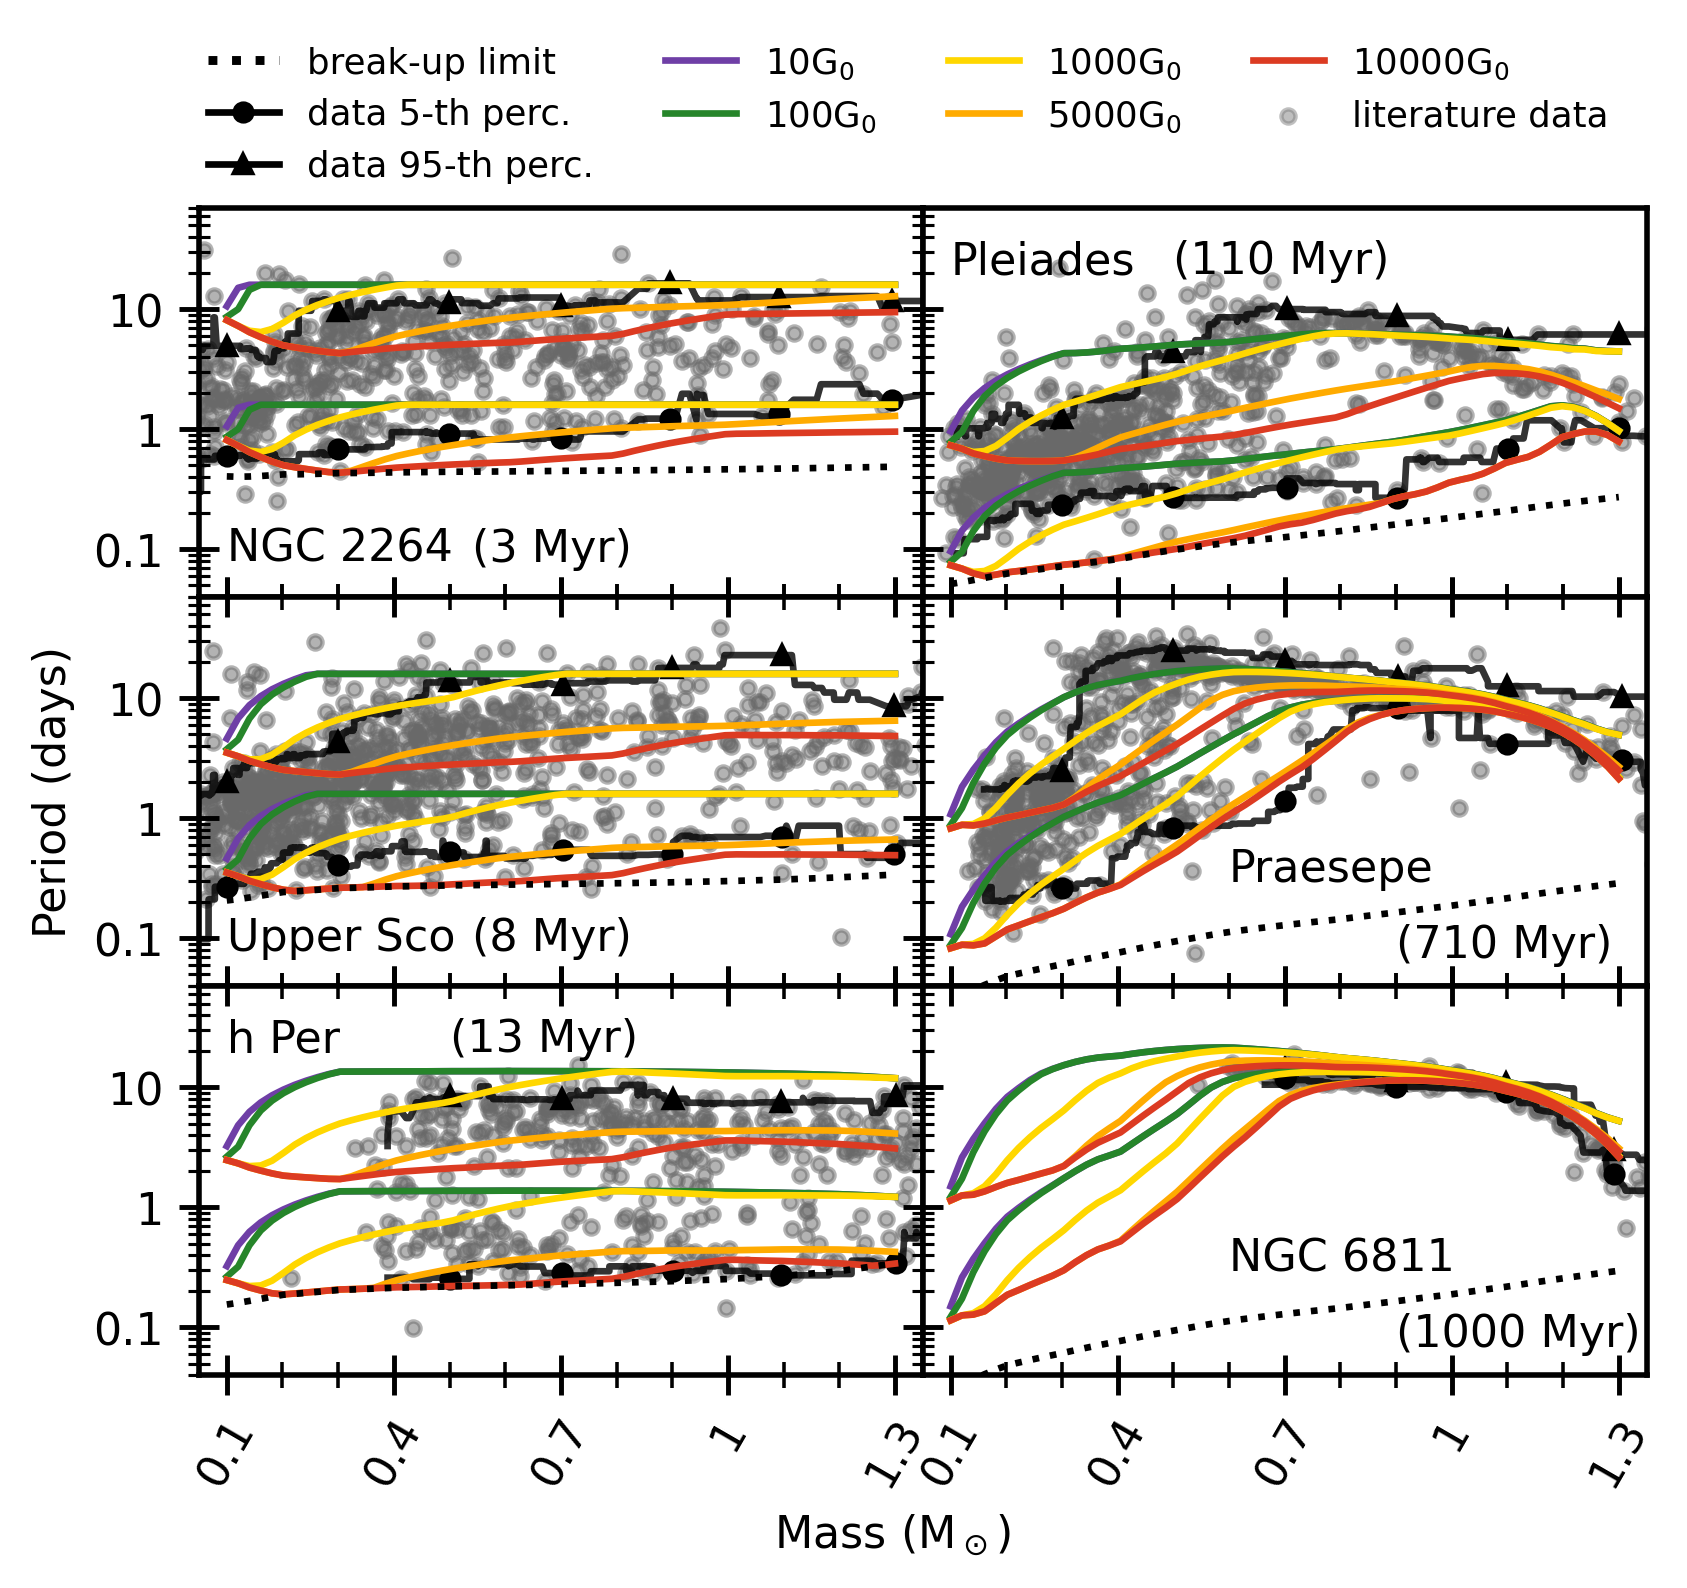

In [63]:
fig, axis = plt.subplots(3, 2, figsize=(5.2, 4.8), dpi=320, sharex=True, 
                         sharey=True)
plt.subplots_adjust(left=0.12, right=0.99, bottom=0.12, top=0.88)
plt.subplots_adjust(wspace=0., hspace=0)
axis_ = [(0,0), (1,0), (2,0), (0,1), (1,1), (2,1)]
fs = 10
x = []; z = []
lw = 1.5
alpha = 0.8
nn = 0
s = 10
mkr = ['o', '^']

axis[0, 0].scatter(-1, -1, s=s, c='gray', alpha=0.5, 
                   label='literature data', zorder=0)
axis[0, 0].plot([-10, -20], [-10, -20], ':', color='k', lw=2, 
                label=r'break-up limit', zorder=0)


for c, qt in enumerate([0.05, .95]):
    axis[0, 0].plot([-1, -1.1], [-1., -1.1], mkr[c], ms=4, color='k', label=
                    'data ' + str(int(100*qt)) + '-th perc.', linestyle='-',
                    lw=lw)

for i, t in enumerate(time[:-1]):
    ax = axis[axis_[i]]
    ax.set_yscale("log")  
    ax.set_ylim(0.04, 70)
    ax.set_xlim(0.05, 1.35)    
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([0.1, 1, 10]))       
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([0.2, 0.3, 0.5, 0.6, 
                                                        0.8, 0.9, 1.1, 1.2]))
    #set y ticks
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())         
    ax.tick_params(axis="y", which='minor', direction="inout", 
                       length=5, width=0.7)    
    ax.tick_params(axis="y", direction="inout", length=9, 
                       width=1.1)       
    ax.set_yticklabels([0.1, 1, 10], fontsize=fs)    
    if i == 1: 
        ax.set_ylabel(r'Period (days)', fontsize=fs)  
    #set x ticks
    if i not in [0, 3]:
        ax.tick_params(axis="x", which="minor", direction="inout", length=6, 
                   width=0.8, top=True) 
        ax.tick_params(axis="x", direction="inout", length=9, width=1.1, 
                       rotation=60, top=True)        
    else:
        ax.tick_params(axis="x", which="minor", direction="inout", length=6, 
                   width=0.8)            
        ax.tick_params(axis="x", direction="inout", length=9, width=1.1)
    if i in [2, 5]:
        ax.set_xticks([0.1, 0.4, 0.7, 1., 1.3])
        ax.set_xticklabels([0.1, 0.4, 0.7, 1, 1.3], fontsize=fs)
    if i == 2: 
        ax.set_xlabel(\
           r'                                               Mass (M$_\odot$)',
                      fontsize=fs)         
    for FUV in disk.FUV:
        if FUV in disk.FUV:
            ax.plot(paper_isogyrochrones['1Myr']['slow'][str(int(FUV)) + \
                     'G0']['Mass'], paper_isogyrochrones['1Myr']['slow']\
                    [str(int(FUV)) + 'G0']['Period'][i+1], '-', 
                    label=r"{0}G$_0$".format(int(FUV)), 
                    color=cmapFUV(normFUV(np.log10(FUV))), lw=lw)
            ax.plot(paper_isogyrochrones['1Myr']['fast'][str(int(FUV)) + \
                    'G0']['Mass'], paper_isogyrochrones['1Myr']['fast']\
                    [str(int(FUV))+'G0']['Period'][i+1], '-', 
                    color=cmapFUV(normFUV(np.log10(FUV))), lw=lw)            

    if i in [0 ,1]: 
        ax.text(.54, .08, '(' + str(int(t/1e6)) + ' Myr)', fontsize=fs)
        ax.text(.1, .08, cluster_name[i], fontsize=fs )  
    elif i in [4, 5]: 
        ax.text(0.9, .07,'(' + str(int(t/1e6)) + ' Myr)', fontsize=fs)
        ax.text(0.6, .3, cluster_name[i], fontsize=fs)   
    else: 
        ax.text(.5, 20, '(' + str(int(t/1e6)) + ' Myr)', fontsize=fs)
        ax.text(.1, 20, cluster_name[i], fontsize=fs)
    # plot cluster data
    x = Mass[i]
    y = Period[i]
    mass_range_ = np.where((x >= 0.0) & (x <= 1.4))[0]
    x = x[mass_range_]
    y = y[mass_range_]    
    a = ax.scatter(x, y, s=s, c='dimgray', alpha=0.5, zorder=0)
    plot_percentiles(ax, x, y, percentile=[.05, 0.95], window_size=0.14,
            secondary_window_size=0.05, min_data=10, secondary_min_data=4,
                    zorder=0, ms=4, mkr=mkr)

    ax.plot(breakup[0],breakup[1][i+1],'k:',lw=lw)    
    ax.set_xlim(0.05, 1.35)    
    for ix in ['top', 'bottom', 'left', 'right']:
        ax.spines[ix].set_linewidth(1.25)    

leg = axis[0, 0].legend(ncol=4, fontsize=8, loc="upper center", 
                        bbox_to_anchor=(0.98, 1.5))
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')

plt.savefig(mydir + 'Observational_periodmass_with_1Myr_tauvis_zoom.pdf')    